In [24]:
import sys
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

np.set_printoptions(threshold=sys.maxsize)

In [25]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
testset = datasets.MNIST(root='./data', train=False, transform=transform)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

In [53]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, inner_dim):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, inner_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(inner_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def add_noise(self, image):
        noise = torch.randn(image.size())*97 / 255
        noised = torch.clamp(image + noise, 0, 1)
        return noised

In [54]:
input_dim = 28*28
hidden_dim = 128
inner_dim = 64
learn_rate = 0.001
n_epochs = 10

model = DenoisingAutoencoder(input_dim, hidden_dim, inner_dim)
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learn_rate)

mse_epochs = []
for i in range(n_epochs):
    t_loss = 0
    for image, _ in trainloader:
        image = image.view(-1, input_dim)
        noised = model.add_noise(image)
        optimizer.zero_grad()
        output = model(noised.view(-1, input_dim))
        loss = loss_func(output, image)
        t_loss += loss.item()
        loss.backward()
        optimizer.step()
    mse_epochs.append(t_loss/len(trainloader))
    print('Epoch: {}/{} Loss: {:.4f}'.format(1+i, n_epochs, t_loss/len(trainloader)))

Epoch: 1/10 Loss: 0.0370
Epoch: 2/10 Loss: 0.0210
Epoch: 3/10 Loss: 0.0179
Epoch: 4/10 Loss: 0.0163
Epoch: 5/10 Loss: 0.0154
Epoch: 6/10 Loss: 0.0148
Epoch: 7/10 Loss: 0.0143
Epoch: 8/10 Loss: 0.0139
Epoch: 9/10 Loss: 0.0136
Epoch: 10/10 Loss: 0.0133


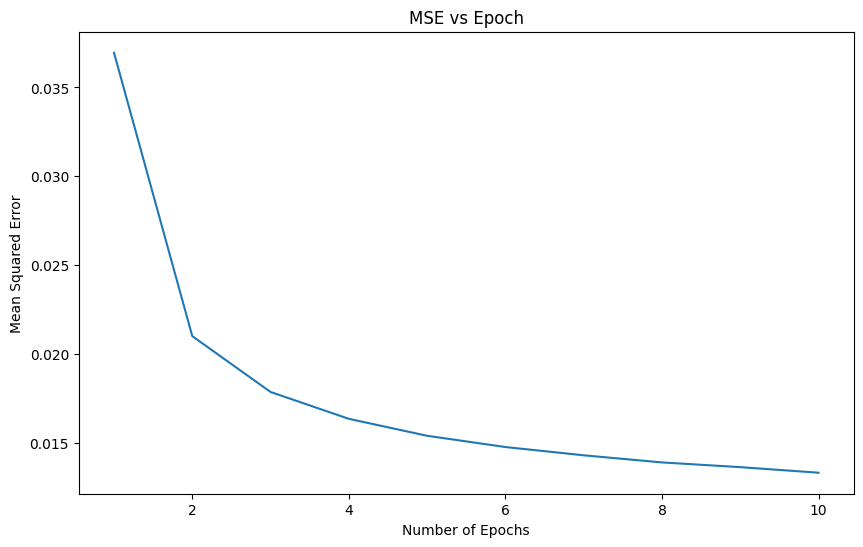

In [55]:
# Plot the MSE vs Epoch curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs+1), mse_epochs)
plt.xlabel('Number of Epochs')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Epoch')
plt.show()

In [58]:
# Evaluate on the test dataset
model.eval()
t_loss = 0

original_images = []
noisy_images = []
denoised_images = []

for i, (image, _) in enumerate(testloader):
    image = image.view(-1, input_dim)
    noised = model.add_noise(image)
    with torch.no_grad():
        output = model(noised.view(-1, input_dim))
    loss = loss_func(output, image)
    t_loss += loss.item()
    if i < 10:
        original_images.append(image[0].view(28, 28).numpy())
        noisy_images.append(noised[0].view(28, 28).numpy())
        denoised_images.append(output[0].view(28, 28).numpy())

print('Test Loss: {:.4f}'.format(t_loss/len(testloader)))

Test Loss: 0.0129


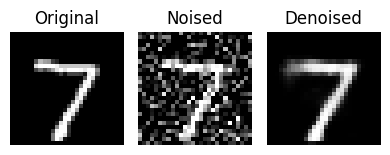

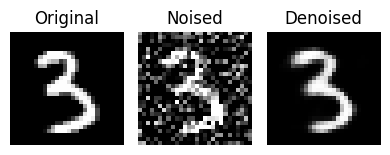

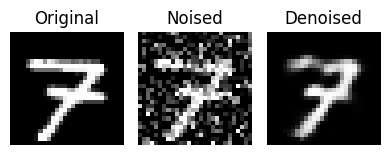

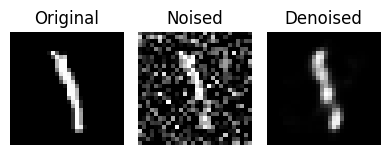

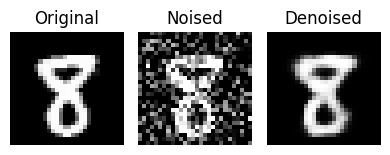

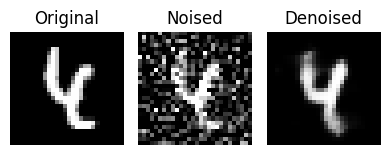

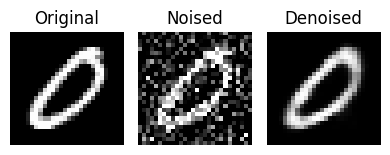

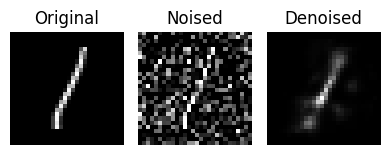

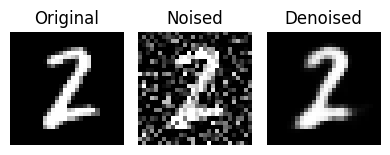

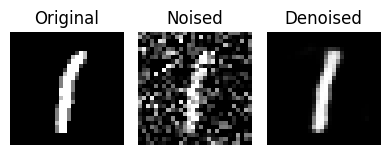

In [57]:
# Plot the images of 10 samples
for i in range(10):
    plt.figure(figsize=(4, 2))
    plt.subplot(131)
    plt.imshow(original_images[i], cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(132)
    plt.imshow(noisy_images[i], cmap='gray')
    plt.title('Noised')
    plt.axis('off')

    plt.subplot(133)
    plt.imshow(denoised_images[i], cmap='gray')
    plt.title('Denoised')
    plt.axis('off')

    plt.tight_layout()
    plt.show()